In [11]:
# import autosklearn.classification
from pipeline import *

# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
models = [
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    #lambda: LogisticRegression(max_iter=1000, random_state=42),
    lambda: SVC(C=1.0, kernel='rbf', probability=True),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=5),
    lambda: DecisionTreeClassifier(max_depth=5, random_state=42),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

def run_window_decay(model, year):
    l = []

    # param_grids = [
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [5, 10, None],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'C': [1.0, 0.1, 0.01],
    #         'kernel': ['rbf', 'linear'],
    #         'probability': [True]
    #     },
    #     {},
    #     {
    #         'n_neighbors': [5, 10, 15],
    #         'weights': ['uniform', 'distance']
    #     },
    #     {
    #         'max_depth': [5, 10, 15],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'learning_rate': [0.1, 0.01, 0.001],
    #         'max_depth': [3, 5, 7],
    #         'random_state': [42]
    #     },
    #     {
    #         'hidden_layer_sizes': [(100, 50), (200, 100), (300, 150)],
    #         'max_iter': [1000, 2000, 3000],
    #         'random_state': [42]
    #     }
    #     ]

    clf = model()
    decay_rate=0.1
    df_teams_merged = []
    test = []
    train = []
    for i in range(2, year + 1):
        df_teams_merged = pipeline_clf(year=i)
        weight = decay_rate ** (10 - i - 1)

        df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

        train = df_teams_merged[df_teams_merged['year'] < i]
        test = df_teams_merged[df_teams_merged['year'] == i]

        #if (year == i):
        #    break


        X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
        y_train = train['playoff']
        sample_weight = [weight] * len(X_train)

        # grid_search_results = []
        # best_model = None
        # best_score = 0

        # # Perform grid search for each model
        # for model, param_grid in zip(models, param_grids):
        #     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        #     grid_search.fit(train.drop(['playoff', 'year', 'tmID'], axis=1), train['playoff'])  # Replace X and y with your data
        #     grid_search_results.append(grid_search)
        #     if grid_search.best_score_ > best_score:
        #         best_score = grid_search.best_score_
        #         best_model = grid_search.best_estimator_

        # for model, grid_search_result in zip(models, grid_search_results):
        #     print(f"Best parameters for {model.__class__.__name__}: {grid_search_result.best_params_}")
        #     print(f"Best score for {model.__class__.__name__}: {grid_search_result.best_score_}")

        # clf = best_model

        if type(model()).__name__ in ["KNeighborsClassifier", "MLPClassifier"]:
            clf.fit(X_train, y_train)  # This model don't support sample weights
        else:
            clf.fit(X_train, y_train, sample_weight=sample_weight)

    predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
    test['predictions'] = predictions
    df_teams_merged['predictions'] = 0
    df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

    # print the year and the predicted scores
    # print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


    df_teams, ea_teams, we_teams = classify_playoff_entry(
            df_teams_merged, year)

    ea_predictions = ea_teams['tmID'].unique()
    we_predictions = we_teams['tmID'].unique()


    accuracy = calculate_playoff_accuracy(
        year, ea_predictions, we_predictions, display_results = False)

    return accuracy


/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05       0.05       1.         1.         1.         0.75
 0.58064516 1.         1.         1.         1.         0.05      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
56   IND    11            1.093206            1.203242     EA      1.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     1.000000  
56              -0.101166  0.3750     1.000000  
92               1.291558  0.1250     0.580645  
2               -0.994404  0.1875     0.050000  
14               0.000000  0.0625     0.050000  
153             -0.559367  0.1250     0.050000  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

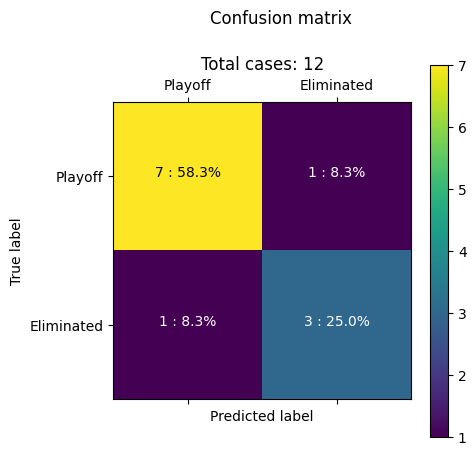

87.5

In [12]:
pipeline_year(11,display_results=True, model=models[4])

    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
56   IND    11            1.093206            1.203242     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     0.800827  
92               1.291558  0.1250     0.746450  
56              -0.101166  0.3750     0.715342  
14               0.000000  0.0625     0.414310  
153             -0.559367  0.1250     0.225649  
2               -0.994404  0.1875     0.200454  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
138  SEA    11            1.416331            1.103757     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.20045374 0.41431048 0.80082725 0.71534245 0.78700395 0.68389483
 0.74645042 0.73988696 0.79388424 0.82212107 0.52436629 0.22564875]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


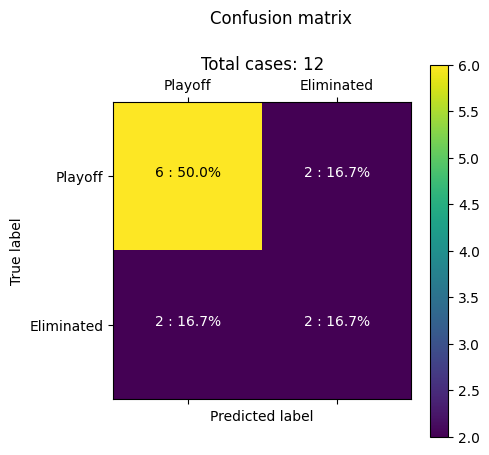

75.0

In [13]:
pipeline_year(11,display_results=True, model=models[1])

    tmID  year  offensive_strength  defensive_strength confID  playoff  \
56   IND    11            1.093206            1.203242     EA      1.0   
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750         0.88  
26               1.180247  0.0625         0.79  
92               1.291558  0.1250         0.60  
14               0.000000  0.0625         0.35  
2               -0.994404  0.1875         0.15  
153             -0.559367  0.1250         0.06  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.15 0.35 0.79 0.88 1.   0.41 0.6  0.37 0.8  0.96 0.61 0.06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


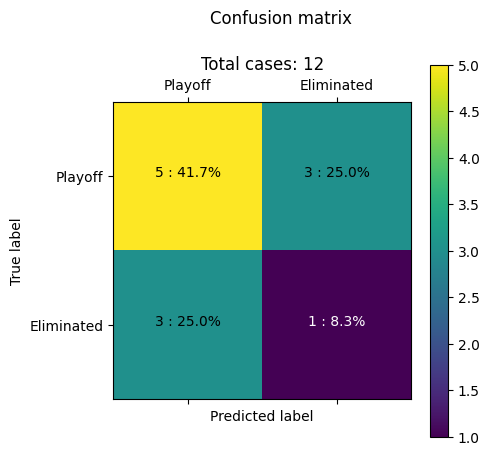

62.5

In [14]:
pipeline_year(11,display_results=True, model=models[0])

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.15 0.35 0.79 0.88 1.   0.41 0.6  0.37 0.8  0.96 0.61 0.06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
56   IND    11            1.093206            1.203242     EA      1.0   
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750         0.88  
26               1.180247  0.0625         0.79  
92               1.291558  0.1250         0.60  
14               0.000000  0.0625         0.35  
2               -0.994404  0.1875         0.15  
153             -0.559367  0.1250         0.06  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

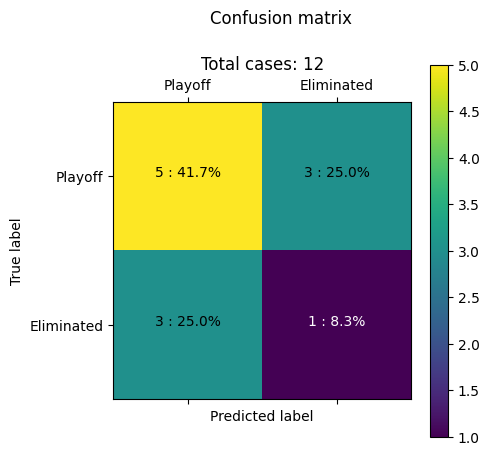

62.5

In [17]:
pipeline_year(11,display_results=True, lightGBM=True)


/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.15 0.35 0.79 0.88 1.   0.41 0.6  0.37 0.8  0.96 0.61 0.06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
56   IND    11            1.093206            1.203242     EA      1.0   
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750         0.88  
26               1.180247  0.0625         0.79  
92               1.291558  0.1250         0.60  
14               0.000000  0.0625         0.35  
2               -0.994404  0.1875         0.15  
153             -0.559367  0.1250         0.06  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.22066633 0.42590637 0.78855543 0.70674913 0.77517153 0.67711066
 0.73627718 0.73002724 0.78182416 0.80932348 0.52851228 0.24563267]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
56   IND    11            1.093206            1.203242     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     0.788555  
92               1.291558  0.1250     0.736277  
56              -0.101166  0.3750     0.706749  
14               0.000000  0.0625     0.425906  
153             -0.559367  0.1250     0.245633  
2               -0.994404  0.1875     0.220666  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
138  SEA    11            1.416331            1.103757     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00196789 0.05891344 0.74780351 0.94821066 0.99341115 0.68080885
 0.19218651 0.89534344 0.9865265  0.99607044 0.96494474 0.02234042]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
56   IND    11            1.093206            1.203242     EA      1.0   
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750     0.948211  
26               1.180247  0.0625     0.747804  
92               1.291558  0.1250     0.192187  
14               0.000000  0.0625     0.058913  
153             -0.559367  0.1250     0.022340  
2               -0.994404  0.1875     0.001968  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
138  SEA    11            1.416331            1.103757     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.2 0.4 0.8 0.4 1.  1.  0.6 0.4 1.  1.  0.8 0.2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
56   IND    11            1.093206            1.203242     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625          0.8  
92               1.291558  0.1250          0.6  
14               0.000000  0.0625          0.4  
56              -0.101166  0.3750          0.4  
2               -0.994404  0.1875          0.2  
153             -0.559367  0.1250          0.2  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05       0.05       1.         1.         1.         0.75
 0.58064516 1.         1.         1.         1.         0.05      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
56   IND    11            1.093206            1.203242     EA      1.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     1.000000  
56              -0.101166  0.3750     1.000000  
92               1.291558  0.1250     0.580645  
2               -0.994404  0.1875     0.050000  
14               0.000000  0.0625     0.050000  
153             -0.559367  0.1250     0.050000  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06379902 0.29589139 0.73502301 0.97817618 0.9889294  0.3813693
 0.89826076 0.48612369 0.89695977 0.97770193 0.63722593 0.06486797]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
56   IND    11            1.093206            1.203242     EA      1.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
26   CON    11            0.869045            0.788144     EA      0.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750     0.978176  
92               1.291558  0.1250     0.898261  
26               1.180247  0.0625     0.735023  
14               0.000000  0.0625     0.295891  
153             -0.559367  0.1250     0.064868  
2               -0.994404  0.1875     0.063799  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
67   LAS    11            1.153442            1.322111     WE   

/home/ricardo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/mnt/c/Users/ricar/OneDrive/Ambiente de Trabalho/ac/pipeline.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.81078091e-05 3.81236010e-01 9.58739197e-01 8.67533057e-01
 9.88082003e-01 9.97427084e-01 2.92459277e-01 3.22593626e-01
 9.91059053e-01 9.99996693e-01 9.52471424e-01 2.20123133e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


    tmID  year  offensive_strength  defensive_strength confID  playoff  \
26   CON    11            0.869045            0.788144     EA      0.0   
56   IND    11            1.093206            1.203242     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     0.958739  
56              -0.101166  0.3750     0.867533  
14               0.000000  0.0625     0.381236  
92               1.291558  0.1250     0.292459  
153             -0.559367  0.1250     0.220123  
2               -0.994404  0.1875     0.000078  
    tmID  year  offensive_strength  defensive_strength confID  playoff  \
138  SEA    11            1.416331            1.103757     WE   

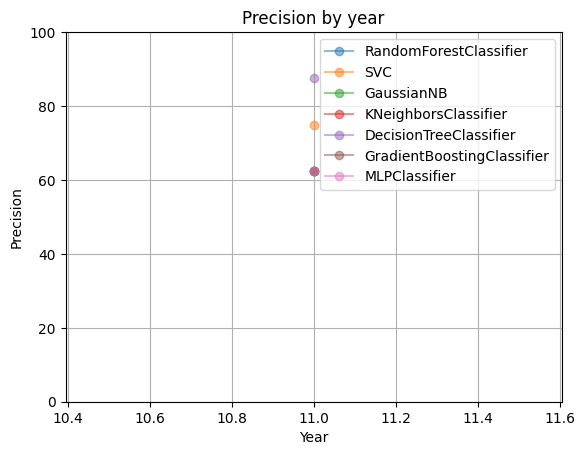

In [16]:
from pipeline import *

def check_accuracy_by_year2(models):
    # Create a list to store accuracy values for each model
    accs = []
    
    # Define the years
    years = list(range(11, 12))
    
    # Calculate accuracy for each year for each model
    for model in models:
        #model_accs = [run_window_decay(model, year) for year in years]
        model_accs = [pipeline_year(year, model=model, display_results=False) for year in years]
        accs.append(model_accs)
    #accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
    print(accs)

    # Plot the accuracy line graphs for each model
    for i, model_acc in enumerate(accs):
        plt.plot(years, model_acc, label=f"{type(models[i]()).__name__ }", marker='o', linestyle='-', alpha=0.5)

    # Add labels for each data point
    # for i, model_acc in enumerate(accs):
    #     for j, acc in enumerate(model_acc):
    #         plt.text(years[j], acc, f"{acc:.2f}", ha="center", va="bottom")

    # Add legend
    plt.legend()

    # Set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Precision")
    plt.title("Precision by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2(models)


In [ ]:
run_window_decay(models[0], 10)

    tmID  year  offensive_strength  defensive_strength confID  playoff  \
36   DET    10            1.537025            1.455432     EA      1.0   
55   IND    10            1.094342            1.254515     EA      1.0   
25   CON    10            0.491682            0.422073     EA      0.0   
1    ATL    10            0.577290            0.617877     EA      1.0   
91   NYL    10            0.125098            0.113457     EA      0.0   
152  WAS    10            0.308563            0.326289     EA      1.0   
13   CHI    10            0.214965            0.221851     EA      0.0   

     win_percentage_coach  awards  predictions  
36               0.000000  0.5000         0.86  
55              -0.432801  0.5625         0.86  
25               1.263359  0.0000         0.78  
1               -2.235235  0.3125         0.53  
91               0.000000  0.0625         0.49  
152              0.000000  0.0000         0.36  
13              -0.565374  0.0625         0.05  
    tmID  year 

/tmp/ipykernel_971/3957204708.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.53 0.05 0.78 0.86 0.86 1.   0.21 0.49 0.53 0.42 0.63 0.66 0.36]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions


87.5

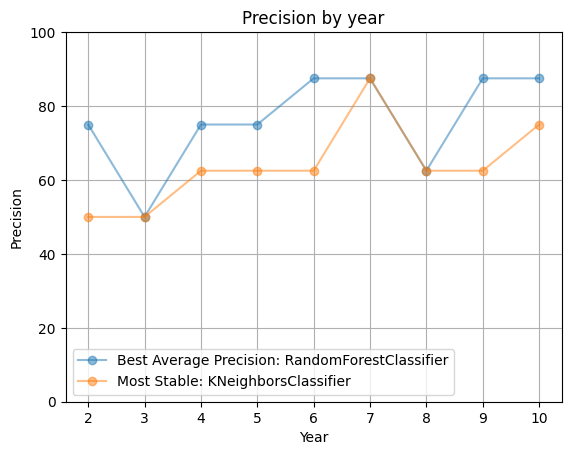

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]

years = list(range(2, 11))
model_names = [type(model()).__name__ for model in models]

# Calculate the average accuracy and standard deviation for each model
avg_accuracies = [np.mean(model_accs) for model_accs in accs]
std_accuracies = [np.std(model_accs) for model_accs in accs]

# Find the index of the model with the highest average accuracy and lowest standard deviation
best_avg_model_index = np.argmax(avg_accuracies)
most_stable_model_index = np.argmin(std_accuracies)

# Plot the accuracy line graphs for the best average model and the most stable model
plt.plot(years, accs[best_avg_model_index], label=f"Best Average Precision: {model_names[best_avg_model_index]}", marker='o', linestyle='-', alpha=0.5)
plt.plot(years, accs[most_stable_model_index], label=f"Most Stable: {model_names[most_stable_model_index]}", marker='o', linestyle='-', alpha=0.5)

# Add legend
plt.legend()

# Set Y-axis limits
plt.ylim(0, 100)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision by year")
plt.grid(True)

plt.show()